In [121]:
# Load Imports
import matplotlib.pyplot
from pyvis.network import Network
import community
import networkx
import pandas
import numpy
import spacy
import json
import os

In [43]:
df_persons = pandas.read_json("./Data/df_persons.json")

In [20]:
# Load English language model
# Use for install en_model_language python -m spacy download en
NLP = spacy.load("en_core_web_sm")

In [12]:
base_path = "./Novel Volumes"
volumes = sorted([volume.rstrip(".txt") for volume in os.listdir(base_path)])

In [16]:
# Read Novel text
volume = volumes[0]
with open(f"{base_path}/{volume}.txt") as f:
    novel_text = f.read()

In [21]:
# Process text 
novel_doc = NLP(novel_text)

In [23]:
# Using displacy to visualize schames found in sentences
# https://spacy.io/models/en -> 
from spacy import displacy
displacy.render(novel_doc[0:300], style="ent")

In [39]:
list_sent_entity = []
for sent in novel_doc.sents:
    if sent.ents:
        list_sent_entity.append({"sentence": sent, 
                                 "entities": [ent.text for ent in sent.ents]})

In [40]:
sent_entity_df = pandas.DataFrame(list_sent_entity)

In [45]:
def filter_entity(ent_list: list, character_df: pandas.DataFrame):
    return [ent for ent in ent_list
            if ent in list(character_df["First Name"]) or ent in list(character_df["Name"])]

In [46]:
sent_entity_df["character_entities"] = sent_entity_df["entities"].apply(lambda x: filter_entity(x, df_persons))

In [52]:
sent_entity_df_filtered = sent_entity_df[sent_entity_df["character_entities"].map(len) > 0].reset_index(drop=True)
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])

In [141]:
# Itentify relationship between the persons

window_size = 5
relation_ships = []
for index in range(sent_entity_df_filtered.index[-1]):
    end_index = min(index + window_size, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[index: end_index].character_entities), [])
    char_unique = [char_list[i] for i in range(len(char_list)) if (i==0) or char_list[i] != char_list[i-1]]
    if len(char_unique) > 1:
        for idx, char_a in enumerate(char_unique[:-1]):
            char_b = char_unique[idx + 1]
            relation_ships.append({"source": char_a, "target": char_b})
    

In [146]:
df_relation_ships = pandas.DataFrame(relation_ships)
# Sort relations_ship a -> b and b -> a
df_relation_ships = pandas.DataFrame(numpy.sort(df_relation_ships.values, axis=1), columns=df_relation_ships.columns)

In [147]:
# Count Number of iterations of each relation_ship
df_relation_ships['value'] = 1
df_relation_ships = df_relation_ships.groupby(["source", "target"], sort=False, as_index=False).sum()

In [148]:
df_relation_ships.head()

,source,target,value
0,Alice,Arthur,75
1,Alice,Reynolds,34
2,Arthur,Reynolds,19
3,Helen,Reynolds,5
4,Adam,Helen,20


In [150]:
# Create networkx fram pandas dataframe
Gph = networkx.from_pandas_edgelist(df_relation_ships, source='source', target='target', edge_attr="value", create_using=networkx.Graph())

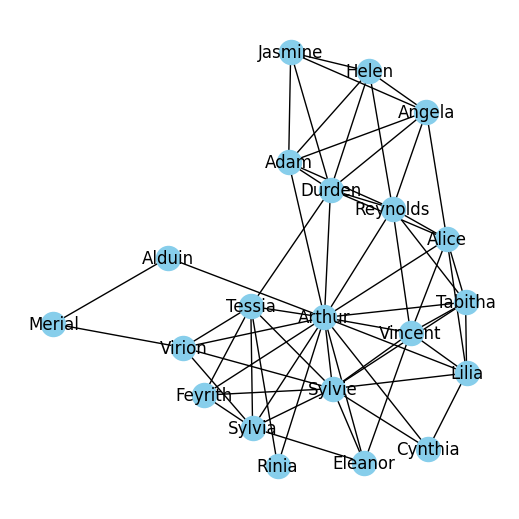

In [151]:
# Plot Simple version of graph
matplotlib.pyplot.figure(figsize=(5, 5))
pos = networkx.kamada_kawai_layout(Gph)
networkx.draw(Gph, with_labels=True, node_color="skyblue", edge_cmap=matplotlib.cm.Blues, pos=pos)

In [162]:
net = Network(notebook=True, width="1800px", height="920px", bgcolor="#121212", font_color="white")

In [163]:
node_degree = dict(Gph.degree)
degree_dict = networkx.degree_centrality(Gph)
betweenness_dict = networkx.betweenness_centrality(Gph)
closeness_dict = networkx.closeness_centrality(Gph)
communities = community.best_partition(Gph)

In [164]:
networkx.set_node_attributes(Gph, node_degree, 'size')
networkx.set_node_attributes(Gph, degree_dict, "degree_centrality")
networkx.set_node_attributes(Gph, betweenness_dict, "betweenness_centrality")
networkx.set_node_attributes(Gph, closeness_dict, "closeness_centrality")
networkx.set_node_attributes(Gph, communities, "group")

In [165]:
net.from_nx(Gph)
net.show(f"./Networks/{volume.replace(' ', '')}.html")